## Term Project Milesone 1 07/05/2022: Identifying High Risk Patient Survival

Kaggle – Patient Survival
https://www.kaggle.com/code/sadiaanzum/patient-survival-prediction/data?select=Dataset.csv

   Since COVID, we have known that our resources to treat patients on an emergency/inpatient level has limitations. Limitations can come in the form of actual resources, ventilators, or staff but the unfortunate outcome has always been the declining health of a patient for not receiving the best care. Electronic health systems and providers do have functionality to mark patients as high-risk but what happens when the hospital is flooded with patients as it was when COVID-19 was dominant in the United States? 
   The problem that I want to identify is how do we go about identifying these high-risk patients through a statistical and data modeling approach? If this is feasible, we can help assist clinicians and hospitals on these high-risk patients that require extra specialize care to reduce death rate and improve patient care. The outcome is to address correlation dependent on hospital death and other variables such as weight, height, gender, BMI, albumin, bilirubin, temperature, age, and heartrate. The idea is to calculate several statistical measurements (R2, RMSE, MAE, r) and apply different models (logistic, linear, lasso, ridge) whenever appropriate, to help identify which variables one should look for that can have correlation to high risk.
   The data set that I choose must have  multiple variables and a significant n value. The purpose for a high patient population is to show statistical significance. I was able to locate a dataset on Kaggle that has all the necessary columns that I need. On first glances, there will have to be some explanatory data analysis as there seems to be several columns that does not relate. There is also an abundance of "NA" values where certain labs weren't logged. This will either have to be replaced by the column mean or removed entirely from the dataset. The dataset does consist of the columns I need which are patients who experienced hospital death and what their (weight, height, gender, BMI, albumin, bilirubin, temperature, age, and heartrate) were. Hopefully by the end of the statistical modeling and analysis, we can find correlation and provide key variables for clinicians to look out for to better serve these patients. 

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC
from math import sqrt
import re
import os
import string
import nltk 
from nltk.corpus import stopwords
import category_encoders as cat_encoder

## Exploring Dataset

In [4]:
# Importing Dataset to Dataframe
df = pd.read_csv('dataset_patients.csv')

In [5]:
# Only selecting patients that passed away during admission
df = df[df['hospital_death'] == 1] 

In [6]:
# Top 5 rows and column headers
df.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
5,557,2854,118,1,72.0,21.955636,0,Caucasian,M,188.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
7,65677,98142,81,1,84.0,NaN,0,Caucasian,M,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma
15,28936,56928,118,1,NaN,36.589292,0,Caucasian,M,182.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,63609,119243,118,1,NaN,21.074715,0,Hispanic,M,182.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,18028,86959,81,1,81.0,32.851562,0,Caucasian,M,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular


In [7]:
# Rows and Columns of dataset
df.shape

(7915, 186)

In [8]:
# Data Types of columns
df.dtypes

encounter_id                     int64
patient_id                       int64
hospital_id                      int64
hospital_death                   int64
age                            float64
                                ...   
leukemia                       float64
lymphoma                       float64
solid_tumor_with_metastasis    float64
apache_3j_bodysystem            object
apache_2_bodysystem             object
Length: 186, dtype: object

In [9]:
# Statistics of numercal data
df.describe()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,...,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
count,7915.000000,7915.000000,7915.000000,7915.0,7273.000000,7552.000000,7915.000000,7725.000000,7915.000000,7915.000000,...,7363.000000,7363.000000,7830.000000,7830.000000,7830.000000,7830.000000,7830.000000,7830.000000,7830.000000,7830.000000
mean,64961.356412,66137.129754,105.412634,1.0,68.494156,28.340398,0.065824,168.952094,509.098547,1.348287,...,0.334838,0.242726,0.001277,0.031673,0.203704,0.027331,0.049042,0.015198,0.008046,0.044317
std,37829.753346,37709.183304,63.927518,0.0,14.428363,8.752581,0.247991,10.844577,212.750331,3.552382,...,0.354252,0.325432,0.035717,0.175139,0.402777,0.163056,0.215970,0.122347,0.089343,0.205811
min,34.000000,1.000000,2.000000,1.0,16.000000,14.844926,0.000000,137.200000,82.000000,-13.775000,...,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,31759.500000,33464.500000,46.000000,1.0,60.000000,22.575554,0.000000,161.000000,374.000000,0.035417,...,0.130000,0.060000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,64761.000000,66372.000000,103.000000,1.0,71.000000,26.635816,0.000000,168.000000,504.000000,0.139583,...,0.300000,0.180000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,97468.000000,99130.000000,171.000000,1.0,80.000000,32.195205,0.000000,177.800000,653.000000,0.795139,...,0.580000,0.435000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,131027.000000,131030.000000,204.000000,1.0,89.000000,67.814990,1.000000,195.590000,927.000000,84.367361,...,0.990000,0.970000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Graphical Analysis

Graph # 1

Below is a histogram of all patients and their age. It is not surprising to see that patients that are over the age of 60 are higher in deaths than in younger and mid age. With poor health management, most diseases like cancer are diagnosis near retirement age. According to cancer.gov, the medican age of cancer diagnosis is over the age of 66.  

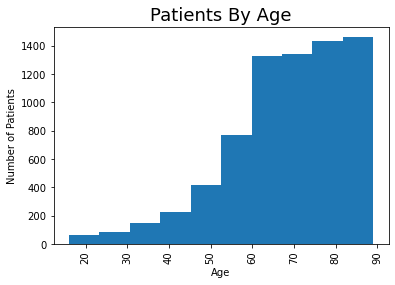

In [10]:
plt.hist(df['age'])
plt.xticks(rotation='vertical')
plt.title("Patients By Age", fontsize=18)
plt.xlabel('Age')
plt.ylabel('Number of Patients')
plt.show()

Graph # 2

The ideal body mass index for children is 2 to 18 and adults is 18 to 25. I chose a scatter plot to plot AGE versus BMI is to see the variation and outliers where patients are considered overweight and obese. Based off the plot below, you can see that there are multiple patients that are overweight and obese which statistically increases heart disease, diabetes and other signficant diseases. 

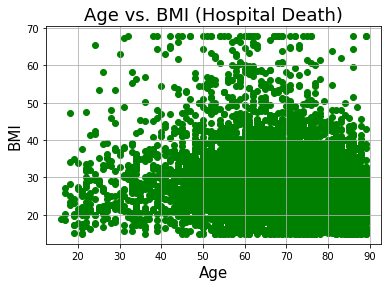

In [11]:
plt.scatter(df['age'],df['bmi'],c='green')
plt.title("Age vs. BMI (Hospital Death)", fontsize=18)
plt.xlabel("Age",fontsize=15)
plt.ylabel("BMI",fontsize=15)
plt.grid(True)
plt.show()

Graph # 3

There are 6 different categorical values for Ethnicity in this dataset. It is very shocking to see that Caucasians make up almost 80% of the death count in this patient dataset. Base off preliminary analysis, Caucasians are immediately considered high risk. Depending on time contraint, I might look at high risk per each ethnicity to see if there is any correlation. It be surprising to find that maybe a specific age group are more prone to cardiac related diseases while another ethnicity might not even classify that as high risk. 

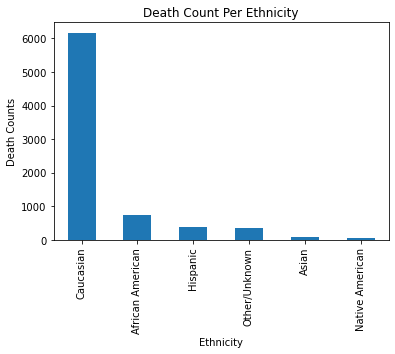

In [12]:
df['ethnicity'].value_counts().plot(kind='bar')
plt.xlabel("Ethnicity")
plt.ylabel("Death Counts")
plt.title("Death Count Per Ethnicity")
plt.show()

Graph # 4

To run general analysis I expect that the Male and Female population should be relatively equal in death rates. The below bar graph confirms this hypothesis. Similar to graph #3, it might be interesting to see if the same variables play a factor in males versus females. 

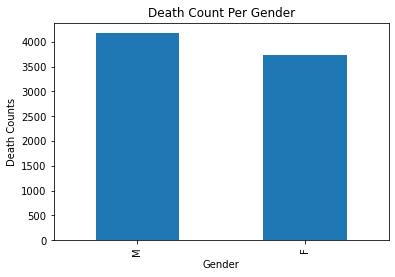

In [13]:
df['gender'].value_counts().plot(kind='bar')
plt.xlabel("Gender")
plt.ylabel("Death Counts")
plt.title("Death Count Per Gender")
plt.show()

Short overview/Conclusion of Preliminary Graphical Analysis

It wasn't shocking to see that the death counts are more dense for individuals over the age of 65+. It is also wasn't surprising to see that the patient death population of 7915 patients were split relatively evenly between males and females. What was shocking was to see that Caucasians accounted for almost 78% of the full death count. This does change our account of correlation whatever the end result is that we utilize to consider a patient as high-risk, will fall towards the Caucasian ethnicity population. The very interesting plot was the scatter on age versus BMI. Almost 35% of this patient population falls out of the normal standard BMI for their age. This means that they are more at risk for such diseases as coronary disease, diabetes, stroke and many others. 

## Term Project Milestone 2 07/18/2022: Data Preparation

For this milesone we will proceed with cleaning the dataset to prep it prior to our model analysis.

In [14]:
df.head(5)

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
5,557,2854,118,1,72.0,21.955636,0,Caucasian,M,188.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
7,65677,98142,81,1,84.0,NaN,0,Caucasian,M,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma
15,28936,56928,118,1,NaN,36.589292,0,Caucasian,M,182.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,63609,119243,118,1,NaN,21.074715,0,Hispanic,M,182.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,18028,86959,81,1,81.0,32.851562,0,Caucasian,M,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular


In [15]:
# Selecting only specific columns that pertains to the dataset. The original dataset has 186 columns. Instead of dropping and 
# naming these specific columns, I will only select the 30 that I think will pertain most to answering my question and 
# supporting my hypothesis.

df2 = df[['hospital_death', 'age', 'bmi', 'elective_surgery', 'ethnicity', 'gender', 'height', 'readmission_status', 
                      'weight', 'albumin_apache', 'bilirubin_apache', 'creatinine_apache', 'glucose_apache', 'heart_rate_apache',
                      'hematocrit_apache', 'intubated_apache', 'resprate_apache', 'sodium_apache', 'temp_apache', 'ventilated_apache',
                      'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure', 'immunosuppression', 'leukemia', 'leukemia',
                      'lymphoma', 'solid_tumor_with_metastasis', 'apache_3j_bodysystem']]

In [16]:
df2.head(5)

,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,readmission_status,weight,albumin_apache,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem
5,1,72.0,21.955636,0,Caucasian,M,188.0,0,77.6,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological
7,1,84.0,NaN,0,Caucasian,M,NaN,0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma
15,1,NaN,36.589292,0,Caucasian,M,182.9,0,122.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,1,NaN,21.074715,0,Hispanic,M,182.9,0,70.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,1,81.0,32.851562,0,Caucasian,M,160.0,0,84.1,3.1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular


In [17]:
df2.shape

(7915, 30)

In [18]:
# Looking for Nulls in the dataset
df2.isna().sum()

hospital_death                    0
age                             642
bmi                             363
elective_surgery                  0
ethnicity                       105
gender                            8
height                          190
readmission_status                0
weight                          241
albumin_apache                 3758
bilirubin_apache               4152
creatinine_apache              1452
glucose_apache                  841
heart_rate_apache               106
hematocrit_apache              1580
intubated_apache                 85
resprate_apache                 123
sodium_apache                  1372
temp_apache                     559
ventilated_apache                85
aids                             85
cirrhosis                        85
diabetes_mellitus                85
hepatic_failure                  85
immunosuppression                85
leukemia                         85
leukemia                         85
lymphoma                    

In [19]:
df2.dtypes

hospital_death                   int64
age                            float64
bmi                            float64
elective_surgery                 int64
ethnicity                       object
gender                          object
height                         float64
readmission_status               int64
weight                         float64
albumin_apache                 float64
bilirubin_apache               float64
creatinine_apache              float64
glucose_apache                 float64
heart_rate_apache              float64
hematocrit_apache              float64
intubated_apache               float64
resprate_apache                float64
sodium_apache                  float64
temp_apache                    float64
ventilated_apache              float64
aids                           float64
cirrhosis                      float64
diabetes_mellitus              float64
hepatic_failure                float64
immunosuppression              float64
leukemia                 

In [20]:
# For the missing values I will only utilize the mean for AGE, BMI, Height, and Weight. All other values that are missing 
# I will completely remove from the dataset. The explanation to why will be explained below. 

df2[['age', 'bmi']] = df2[['age', 'bmi']].fillna(df2[['age', 'bmi']].mean())
df2[['height', 'weight']] = df2[['height', 'weight']].fillna(df2[['height', 'weight']].mean())

C:\Users\qvant\anaconda3\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [21]:
# Instead of replacing the nulls with the mean, median or mode, I ultimate decided to remove all rows that contains nulls. In
# most datasets, it would be advantageous but when dealing with population health data, I highly disagree. One of the reasons
# is that even when we select the mean, median or mode, if there is enough null/missing data, we can falsely apply these metrics
# when in real life situations this type of data has very high variance. As long as there is still a at least half of the original
# dataset to work with, I will be satisfied. 
df3 = df2.dropna()

In [22]:
df3.isna().sum()

hospital_death                 0
age                            0
bmi                            0
elective_surgery               0
ethnicity                      0
gender                         0
height                         0
readmission_status             0
weight                         0
albumin_apache                 0
bilirubin_apache               0
creatinine_apache              0
glucose_apache                 0
heart_rate_apache              0
hematocrit_apache              0
intubated_apache               0
resprate_apache                0
sodium_apache                  0
temp_apache                    0
ventilated_apache              0
aids                           0
cirrhosis                      0
diabetes_mellitus              0
hepatic_failure                0
immunosuppression              0
leukemia                       0
leukemia                       0
lymphoma                       0
solid_tumor_with_metastasis    0
apache_3j_bodysystem           0
dtype: int

In [23]:
# There is still a significant number of patients left that is over 3,000 which we can proceed with the dataset. So far, we have
# not manipulated any data and made zero assumptions. Thus, the outcome will be more accurate to the source and correlation.

df3.shape

(3320, 30)

In [24]:
df3.head(5)

,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,readmission_status,weight,albumin_apache,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem
4134,1,48.0,24.047217,0,Caucasian,M,168.90,0,68.6,1.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic
4144,1,67.0,28.146291,0,Caucasian,M,167.64,0,79.1,2.1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Sepsis
4148,1,55.0,43.290027,0,Caucasian,F,165.10,0,118.0,2.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis
4153,1,64.0,43.348537,0,Caucasian,F,160.02,0,111.0,1.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological
4156,1,43.0,28.168975,0,Caucasian,F,170.20,0,81.6,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological


In [25]:
df3.describe()

,hospital_death,age,bmi,elective_surgery,height,readmission_status,weight,albumin_apache,bilirubin_apache,creatinine_apache,...,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,leukemia,lymphoma,solid_tumor_with_metastasis
count,3320.0,3320.000000,3320.000000,3320.000000,3320.000000,3320.0,3320.000000,3320.000000,3320.000000,3320.000000,...,3320.000000,3320.000000,3320.000000,3320.000000,3320.000000,3320.000000,3320.000000,3320.000000,3320.000000,3320.000000
mean,1.0,67.034226,28.750729,0.066867,169.203806,0.0,82.339266,2.538223,1.966669,2.146141,...,0.716867,0.001205,0.046386,0.222892,0.039759,0.058434,0.019277,0.019277,0.007229,0.048494
std,0.0,14.399267,8.677663,0.249830,10.856391,0.0,25.917003,0.687455,3.676320,1.684012,...,0.450588,0.034695,0.210350,0.416249,0.195422,0.234597,0.137518,0.137518,0.084728,0.214840
min,1.0,16.000000,14.844926,0.000000,137.200000,0.0,38.600000,1.200000,0.100000,0.300000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,59.000000,23.068366,0.000000,162.500000,0.0,64.800000,2.000000,0.500000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.0,68.494156,27.352748,0.000000,170.000000,0.0,79.500000,2.500000,0.900000,1.700000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.0,78.000000,32.360338,0.000000,177.800000,0.0,94.000000,3.000000,1.700000,2.670000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.0,89.000000,67.814990,1.000000,195.590000,0.0,186.000000,4.600000,38.400000,11.180000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
df3.describe(include='object')

,ethnicity,gender,apache_3j_bodysystem
count,3320,3320,3320
unique,6,2,10
top,Caucasian,M,Cardiovascular
freq,2613,1792,1051


In [27]:
# The data consist of categorical and continous variables/columns. I will proceed to create dummy variables for all the 
# categorical data.

df4 = pd.get_dummies(df3, columns = ['ethnicity',
'gender',
'apache_3j_bodysystem'], drop_first = True)

In [28]:
# To display more columns
pd.options.display.max_columns = 200

In [29]:
# To display more results
pd.options.display.max_rows = 4000

In [30]:
df4.head(5)

,hospital_death,age,bmi,elective_surgery,height,readmission_status,weight,albumin_apache,bilirubin_apache,creatinine_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,resprate_apache,sodium_apache,temp_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,leukemia,lymphoma,solid_tumor_with_metastasis,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,gender_M,apache_3j_bodysystem_Gastrointestinal,apache_3j_bodysystem_Genitourinary,apache_3j_bodysystem_Hematological,apache_3j_bodysystem_Metabolic,apache_3j_bodysystem_Musculoskeletal/Skin,apache_3j_bodysystem_Neurological,apache_3j_bodysystem_Respiratory,apache_3j_bodysystem_Sepsis,apache_3j_bodysystem_Trauma
4134,1,48.0,24.047217,0,168.90,0,68.6,1.6,8.5,2.2,39.0,174.0,28.7,1.0,51.0,138.0,39.7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0
4144,1,67.0,28.146291,0,167.64,0,79.1,2.1,0.8,0.8,150.0,140.0,27.4,0.0,54.0,139.0,39.7,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0
4148,1,55.0,43.290027,0,165.10,0,118.0,2.9,1.1,2.2,261.0,159.0,20.0,1.0,60.0,135.0,39.7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4153,1,64.0,43.348537,0,160.02,0,111.0,1.4,0.6,1.2,424.0,127.0,38.7,1.0,57.0,119.0,39.7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
4156,1,43.0,28.168975,0,170.20,0,81.6,4.0,0.3,2.2,241.0,174.0,31.0,1.0,40.0,158.0,39.7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0


In [31]:
# Confirmation of increase in columns for dummy variables to turn into binary
df4.shape

(3320, 42)

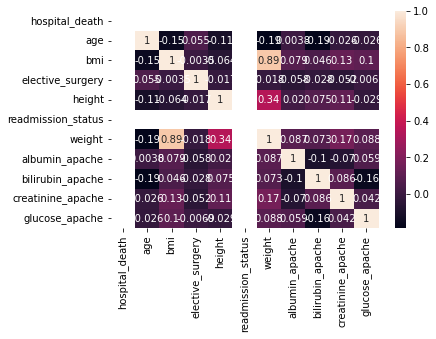

In [32]:
# Correlation Coefficent Matrix to look at highly correlated variables
df4_corr = df4.iloc[:,:11]
correlation_mat = df4_corr.corr()
sns.heatmap(correlation_mat, annot = True)
plt.show()

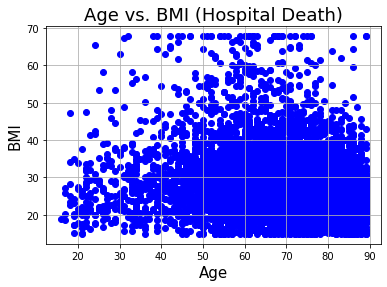

In [33]:
# After cleaned dataset, re-doing some graphs to see distribution
plt.scatter(df['age'],df['bmi'],c='Blue')
plt.title("Age vs. BMI (Hospital Death)", fontsize=18)
plt.xlabel("Age",fontsize=15)
plt.ylabel("BMI",fontsize=15)
plt.grid(True)
plt.show()

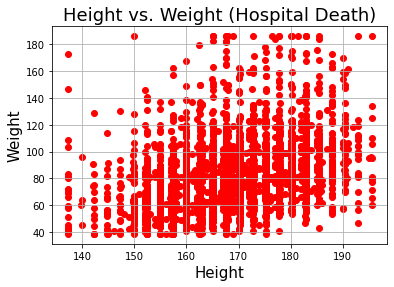

In [34]:
# After cleaned dataset, re-doing some graphs to see distribution
plt.scatter(df3['height'],df3['weight'],c='Red')
plt.title("Height vs. Weight (Hospital Death)", fontsize=18)
plt.xlabel("Height",fontsize=15)
plt.ylabel("Weight",fontsize=15)
plt.grid(True)
plt.show()

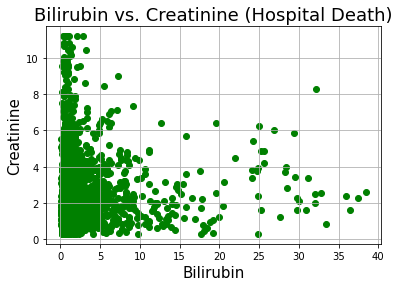

In [35]:
# After cleaned dataset, re-doing some graphs to see distribution
plt.scatter(df3['bilirubin_apache'],df3['creatinine_apache'],c='Green')
plt.title("Bilirubin vs. Creatinine (Hospital Death)", fontsize=18)
plt.xlabel("Bilirubin",fontsize=15)
plt.ylabel("Creatinine",fontsize=15)
plt.grid(True)
plt.show()

After reviewing the dataset, I need to revert and include patients who survived the admission. This way, I can truly compare both datasets (survived / not survived) to see which is a factor. There can be a scenario where males may be predominate in the non-survival category but the full dataset could've been more males in general and we are making an assumption. Below will be steps to repeat the above. 

In [36]:
df = pd.read_csv('dataset_patients.csv')

df2 = df[['hospital_death', 'age', 'bmi', 'elective_surgery', 'ethnicity', 'gender', 'height', 'readmission_status', 
                      'weight', 'albumin_apache', 'bilirubin_apache', 'creatinine_apache', 'glucose_apache', 'heart_rate_apache',
                      'hematocrit_apache', 'intubated_apache', 'resprate_apache', 'sodium_apache', 'temp_apache', 'ventilated_apache',
                      'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure', 'immunosuppression', 'leukemia', 'leukemia',
                      'lymphoma', 'solid_tumor_with_metastasis', 'apache_3j_bodysystem']]

In [37]:
df2.shape

(91713, 30)

In [49]:
df2[['age', 'bmi']] = df2[['age', 'bmi']].fillna(df2[['age', 'bmi']].mean())
df2[['height', 'weight']] = df2[['height', 'weight']].fillna(df2[['height', 'weight']].mean())

In [39]:
df3 = df2.dropna()

In [40]:
df3.isna().sum()

hospital_death                 0
age                            0
bmi                            0
elective_surgery               0
ethnicity                      0
gender                         0
height                         0
readmission_status             0
weight                         0
albumin_apache                 0
bilirubin_apache               0
creatinine_apache              0
glucose_apache                 0
heart_rate_apache              0
hematocrit_apache              0
intubated_apache               0
resprate_apache                0
sodium_apache                  0
temp_apache                    0
ventilated_apache              0
aids                           0
cirrhosis                      0
diabetes_mellitus              0
hepatic_failure                0
immunosuppression              0
leukemia                       0
leukemia                       0
lymphoma                       0
solid_tumor_with_metastasis    0
apache_3j_bodysystem           0
dtype: int

In [41]:
df4 = pd.get_dummies(df3, columns = ['ethnicity',
'gender',
'apache_3j_bodysystem'], drop_first = True)

In [42]:
df4.shape

(30143, 43)

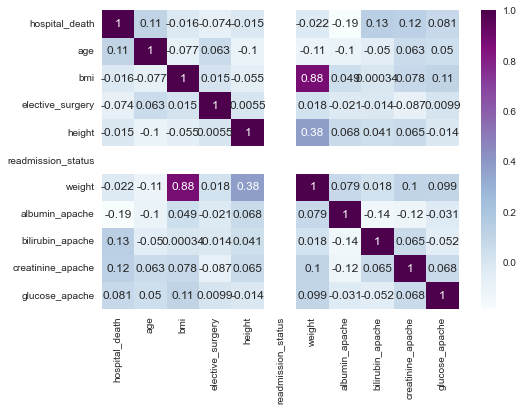

In [108]:
df4_corr = df4.iloc[:,:11]
correlation_mat = df4_corr.corr()
sns.heatmap(correlation_mat, cmap="BuPu", annot = True)
plt.show()

Now that the data is fixed, we will start to create the X and y variables and the training and test datasets. After this is done, we then can proceed to train and evaluating the different models. 

In [44]:
# Splitting the data into training and test
# Hospital Death upon admission will be the target
X = df4.drop(['hospital_death'], axis = 1)
y = df4['hospital_death']

In [45]:
# Splitting the data into 80 Train and 20 Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

In [46]:
print(X_train.shape)
print(X_test.shape)

(24114, 42)
(6029, 42)


In [47]:
print(y_train.value_counts())
print(y_test.value_counts())

0    21462
1     2652
Name: hospital_death, dtype: int64
0    5361
1     668
Name: hospital_death, dtype: int64


In [48]:
print(X_train.isna().sum())
print(X_test.isna().sum())

age                                          0
bmi                                          0
elective_surgery                             0
height                                       0
readmission_status                           0
weight                                       0
albumin_apache                               0
bilirubin_apache                             0
creatinine_apache                            0
glucose_apache                               0
heart_rate_apache                            0
hematocrit_apache                            0
intubated_apache                             0
resprate_apache                              0
sodium_apache                                0
temp_apache                                  0
ventilated_apache                            0
aids                                         0
cirrhosis                                    0
diabetes_mellitus                            0
hepatic_failure                              0
immunosuppres

## Term Project Milestone 3: August 1st 2022

Now that the data has been cleaned and stuctured multiple models will be fitted to the training and test dataset to see which one shows the highest accuracy. The highest accuracy model will then determine that the measured value falls similar to the actual value. With this, users can use the correct fit and predict which patient might experience hospital death. 

Model#1 : Logisic Regression

In [70]:
# Creating Logistic Regression Model
# Maximizing iter so there won't be any errors
model = LogisticRegression(solver='lbfgs', max_iter=20000)

In [71]:
# Fitting the model with logistic regression
model.fit(X_train, y_train)

LogisticRegression(max_iter=20000)

In [112]:
# Calculating the accuracy of the logistic regression model
pred_cv = model.predict(X_test)
print('Accuracy = ', accuracy_score(y_test,pred_cv))

Accuracy =  0.9001492784873113


Model#2: Random Forest Classifier

In [74]:
# Utilizing randomforest to spit into multipel predictions per class then model is evaluated at the end based off highest hits
randomforest = RandomForestClassifier(random_state=42,n_estimators=150,max_depth=4)

In [75]:
# Fitting the random forest model
randomforest.fit(X_train,y_train)
print(randomforest)

RandomForestClassifier(max_depth=4, n_estimators=150, random_state=42)


In [76]:
y_pred_random_for = randomforest.predict(X_test)
f1 = f1_score(y_test,y_pred_random_for)
print('Accuracy = ', accuracy_score(y_test,y_pred_random_for))

Accuracy =  0.8892021894178139


Model#3: Confusion Matrix

In [104]:
label_encoder = {0: 'Hospital Death', 1: 'Non-Hospital Death'}
cm = ConfusionMatrix(model, encoder = label_encoder,  percent=False)

Model Accuracy: 90.01%


C:\Users\qvant\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


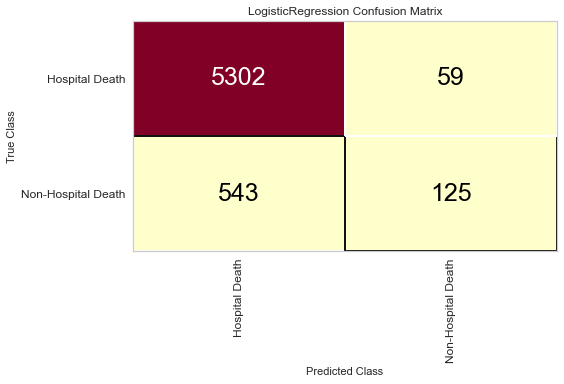

<AxesSubplot:title={'center':'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [105]:
# Fitting the model to confusion matrix
cm.fit(X_test, y_test)
mod_acc = 100*cm.score(X_test, y_test)
print('Model Accuracy: ', round(mod_acc,2), '%', sep = '')

for label in cm.ax.texts:
    label.set_size(25)

cm.show()

Model#4: Roc Curve

C:\Users\qvant\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


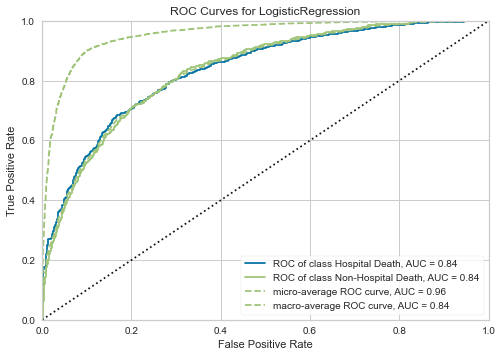

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [107]:
roc_curve = ROCAUC(model, encoder = label_encoder, solver = 'liblinear')

#fit the ROC curve to the test data
roc_curve.fit(X_test, y_test)
#evaluate the model on the test data
roc_curve.score(X_test, y_test)  
roc_curve.show()

After running multiple models, they are have a very close accuracy level of 90%. Logistic regression was at .90 while random forest as at .88. The accuracy of the confusion matrix was at .90 as well. I think it would be very interesting to utilize more models to see if the accuracy can be increased or even potentially increased. When we have a definitive model, we can proceed to confidently train and start predicting which specific variables to look for when patients are admitted. I am a little hesitant as in the heat map of correlation, I didn't see alot of variables that determines non hospital survival versus survival. 